In [1]:
import numpy as np
from numpy import sqrt, exp, absolute

# interactive plots
#%matplotlib notebook
# nice inline plots
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = 16, 9

# Potential

In [2]:
def V(c, x):
    if x < 0 or x > 1:  return 0
    return c*(x*x-x)

# Numerov's Method

The algorithm from the previous exercise, written more concisely.

In [3]:
def numerov_step(k0, k1, k2, psi0, psi1, dx):
    """compute psi2 via a single numerov step"""
    dd = dx**2/12.
    c0 = (1 + dd * k0)
    c1 = 2 * (1 - 5 * dd * k1)
    c2 = (1 + dd * k2)
    # assert not np.isclose(c2, 0.) # slow!
    return (c1 * psi1 - c0 * psi0) / c2

def numerov(k, psi0, psi1, x_min, x_max, n):
    """compute psi = [psi0, psi1, ...] for k(x)"""
    dx = (x_max-x_min)/(n-1)
    k0 = k(x_min)
    k1 = k(x_min+dx)
    psi = np.zeros(n, dtype=np.complex128)
    psi[0] = psi0
    psi[1] = psi1
    dd = dx**2/12.
    for i in range(2, n):
        k2 = k(x_min+i*dx)
        psi[i] = numerov_step(k0, k1, k2, psi[i-2], psi[i-1], dx)
        k0 = k1
        k1 = k2
    return psi

# Shooting for Bound States

Converged after 48 iterations.
found state at E =  -18.00242177603444


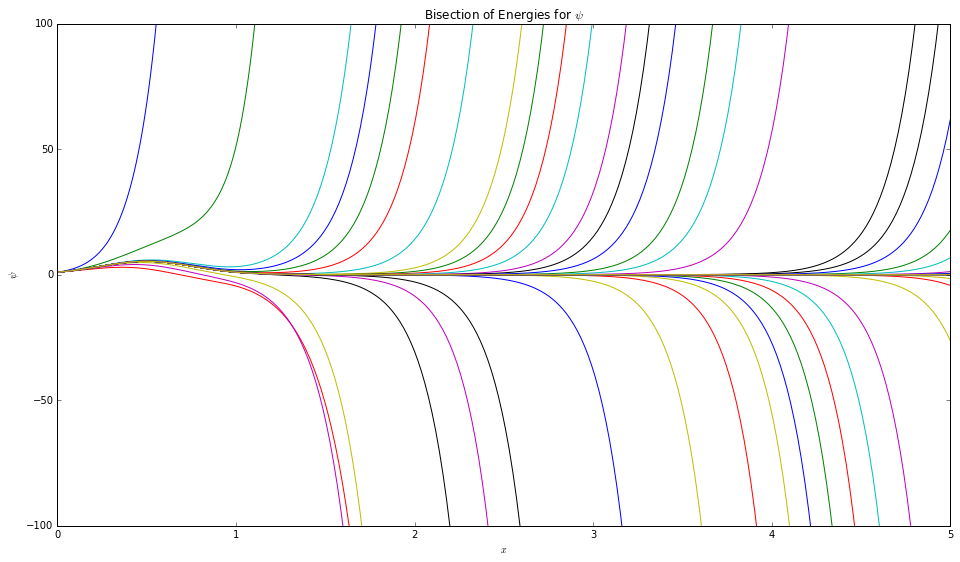

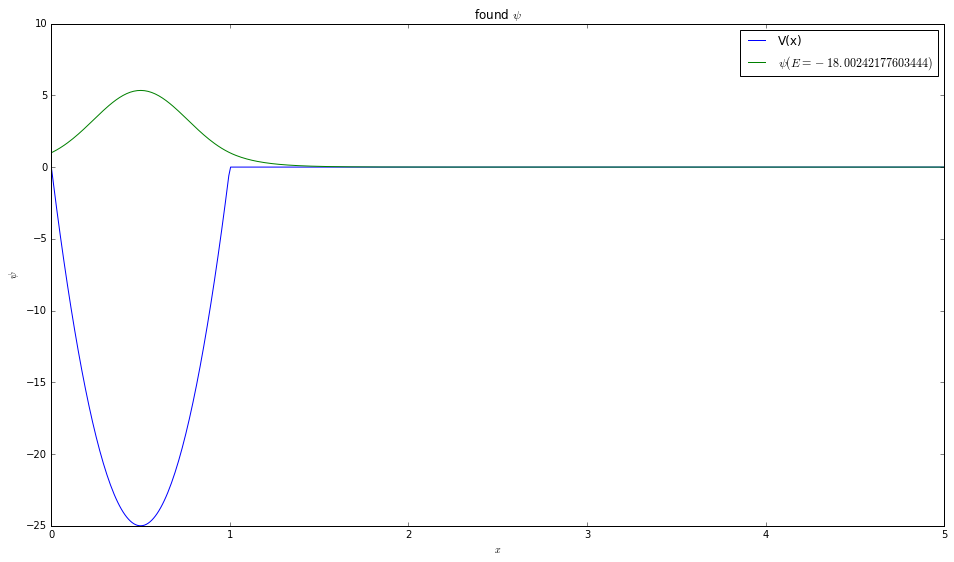

In [5]:
xmax = 5
cV = 100.
stoptol = 0.001
maxiter = 100
steps = int(xmax/0.01) # dx <= 0.01 from ex1

def findstate(energy):
    
    k = lambda x: 2*(energy-V(cV,x))
    
    upper = 0.
    lower = -cV
    psimax = stoptol+1
    dx = xmax/float(steps-0) # change to /(steps-1) -> worse convergence
    
    plt.figure()
    plt.title("Bisection of Energies for $\psi$")
    plt.xlim(0,xmax)
    plt.ylim(-cV,cV)
    plt.xlabel('$x$')
    plt.ylabel('$\psi$')
    
    xs = np.linspace(-dx,xmax,steps)
    it = 0
    while it < maxiter:
        #print(it, ':', energy, 'in [', lower, ',', upper, ']')
        it += 1
        psi0 = exp(1j*dx*sqrt(2*energy+0j))
        psi1 = 1.
        psi = numerov(k,psi0,psi1,-dx,xmax,steps)
        plt.plot(xs,psi.real)
        #plt.plot(xs,psi.imag)
        psimax = psi[-1].real
        if absolute(psimax) <= stoptol:
            print('Converged after', it, 'iterations.')
            plt.figure()
            plt.xlim(0,xmax)
            plt.plot(xs,np.array([V(cV, x) for x in xs]),label='V(x)')
            plt.plot(xs,psi.real,label='$\psi(E='+str(energy)+')$')
            #plt.plot(xs,psi.imag,label='Im, E='+str(energy))
            return energy
        elif psimax > 0.:
            lower = energy
            energy = (upper+energy)/2.
        else:
            upper = energy
            energy = (lower+energy)/2.

    print('Not converged in', maxiter, 'iterations. psimax =', psimax)
    plt.figure()
    plt.ylim(-cV/4.,cV/4.)
    plt.xlim(0,xmax)
    plt.plot(xs,np.array([V(cV, x) for x in xs]),label='V(x)')
    plt.plot(xs,psi.real,label='$\psi(E='+str(energy)+')$')
    #plt.plot(xs,psi.imag,label='Im E='+str(energy))
    return energy

E = findstate(-cV/2.)
print('found state at E = ', E)

plt.title("found $\psi$")
plt.xlabel('$x$')
plt.ylabel('$\psi$')
plt.legend()
plt.show()

We observe that the $\psi$ diverge abruptly. No matter how far we set $xmax$, it will at some point become unphysical.

# Bidirectional Matching

In [6]:
def dlogpsi(k,x_min,x_max,dx,psi0,psi1):
    """
    Return diff(log(psi)) = psi'/psi at x_max and
    how many times psi crosses the x-axis in [x_min, x_max].
    """
    n = int(round((x_max-x_min)/dx))+1
    numnodes = 0
    k0 = k(x_min)
    k1 = k(x_min+dx)
    for i in range(n-2):
        k2 = k(x_min+i*dx)
        psi2 = numerov_step(k0,k1,k2,psi0,psi1,dx)
        psi0 = psi1
        psi1 = psi2
        k0 = k1
        k1 = k2
        if psi0*psi1 < 0: numnodes += 1 # crossing zero
    dpsi = (psi1-psi0)/dx
    return (dpsi/psi1,numnodes)

def matchpsi(energy,cv,dx):
    """
    Chose a matching point and compare the left-to-right and right-to-left psis.
    """
    k = lambda x: 2*(energy-V(cv,x))
    b = .5+sqrt(.25+energy/cv)
    matchx = round(b/dx)*dx
    psi0 = exp(-dx*sqrt(-2.*energy))
    (leftdlog,leftnodes) = dlogpsi(k,-dx,matchx,dx,psi0,1.)
    (rightdlog,rightnodes) = dlogpsi(k,1.+dx,matchx,-dx,psi0,1.)
    return (leftdlog-rightdlog,leftnodes+rightnodes,matchx,psi0,k)

def numboundstates(cv,dx=1.e-3):
    """
    Counting the number of bound stated by the number of nodes for a very high energy:
    energy = -cV * 10^-6
    """
    energy = -cv/1.e6
    (diff,nodes,matchx,psi0,k) = matchpsi(energy,cv,dx)
    if diff > 0:    nodes -= 1
    return nodes+1

#### Count Number of Bound States

In [7]:
cV = 400
dx = 1.e-3
# Computing number of bound states
numstates = numboundstates(cV,dx)
print('# of bound states:', numstates)

# of bound states: 4


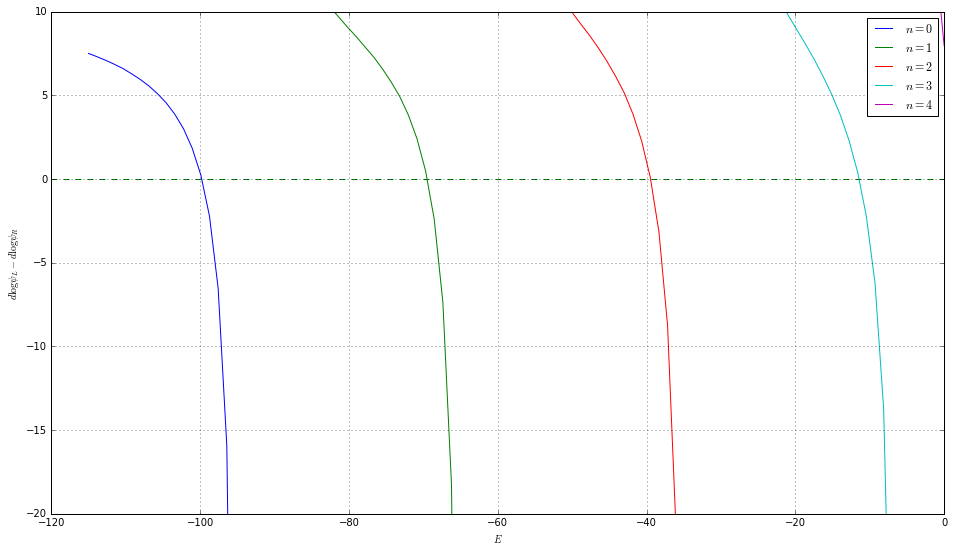

In [13]:
cV = 460

Egrid = []
dlogdiff = []
currnodes = 0
plt.figure()
for E in np.linspace(-cV/4.,0,100):
    (diff,nodes,matchx,psi0,k) = matchpsi(E,cV,dx)
    if nodes == currnodes: # current line
        Egrid.append(E)
        dlogdiff.append(diff)
    else: # start next line
        plt.plot(Egrid,dlogdiff,label='$n=%s$'%currnodes)
        Egrid = []
        dlogdiff = []
        currnodes = nodes
plt.plot(Egrid,dlogdiff,label='$n=%s$'%currnodes)
plt.xlabel('$E$')
plt.ylabel('$d\\log \\psi_L - d\\log \\psi_R$')
plt.ylim(-20,10)
plt.grid()
plt.legend(loc='best')
plt.axhline(0,color='g',linestyle='--')
plt.show()

$\psi_L$ and $\psi_R$ match where the diference $d\log\psi_L - d\log\psi_R$ is zero, which gives a nice visual indicator of the energies for our bound states.

#### Finding Energies

In [9]:
def wavefunction(k,x0,xn,dx,psi0,psi1):
    n = int(round((xn-x0)/dx))+1
    k0 = k(x0)
    k1 = k(x0+dx)
    psi = np.zeros(n)
    psi[0] = psi0
    psi[1] = psi1
    for i in range(2,n):
        k2 = k(x0+i*dx)
        psi[i] = numerov_step(k0, k1, k2, psi[i-2], psi[i-1], dx)
        k0 = k1
        k1 = k2
    return psi

In [10]:
def findstate_match(cv,numnodes=0,dx=1.e-3,stoptol=1.e-5,maxiter=100,verbose=False,plottrials=False):
    emin = -cv/4.
    emax = 0.
    it = 0
    n = int(round((1-0)/dx))+1
    while it < maxiter:
        it += 1
        energy = (emax+emin)/2.
        (diff,nodes,matchx,psi0,k) = matchpsi(energy,cv,dx)
        if verbose:
            print(it, ': E='+str(energy), 'in [', emin, ',', emax, '],\tdiff='+str(diff),'\tnodes='+str(nodes))
        # plot trial wave functions
        if plottrials:
            psil = wavefunction(k,-dx,matchx,dx,psi0,1.)
            psir = wavefunction(k,1.+dx,matchx,-dx,psi0,1.)
            alpha = psil[-1]/psir[-1]
            psi = np.concatenate((psil,alpha*psir[-1::-1]))
            psi /= dx*np.sum(psi)
            xgrid = np.linspace(-dx,1+dx,len(psi))
            plt.plot(xgrid,psi,label='$\psi(E='+str(energy)+')$')
        # converged
        if nodes == numnodes and absolute(diff) < stoptol:
            print('Converged after', it, 'iterations.')
            psil = wavefunction(k,-dx,matchx,dx,psi0,1.)
            psir = wavefunction(k,1.+dx,matchx,-dx,psi0,1.)
            alpha = psil[-1]/psir[-1]
            psi = np.concatenate((psil,alpha*psir[-1::-1]))
            psi /= sqrt(dx*np.sum(psi*psi))
            return (energy,psi)
        # E too low
        elif nodes < numnodes or (nodes == numnodes and diff > 0):
            emin = energy
        # E too high
        else:
            emax = energy

Notice how the "`if nodes == numnodes`" condition allows us to zoom in onto an arbitrary n-th eigenenergy.

+++ 0'th bound state:
Converged after 23 iterations.
E_0 = -85.7972502708435
+++ 1'th bound state:
Converged after 24 iterations.
E_1 = -57.56083130836487
+++ 2'th bound state:
Converged after 22 iterations.
E_2 = -29.761815071105957
+++ 3'th bound state:
Converged after 23 iterations.
E_3 = -5.022060871124268


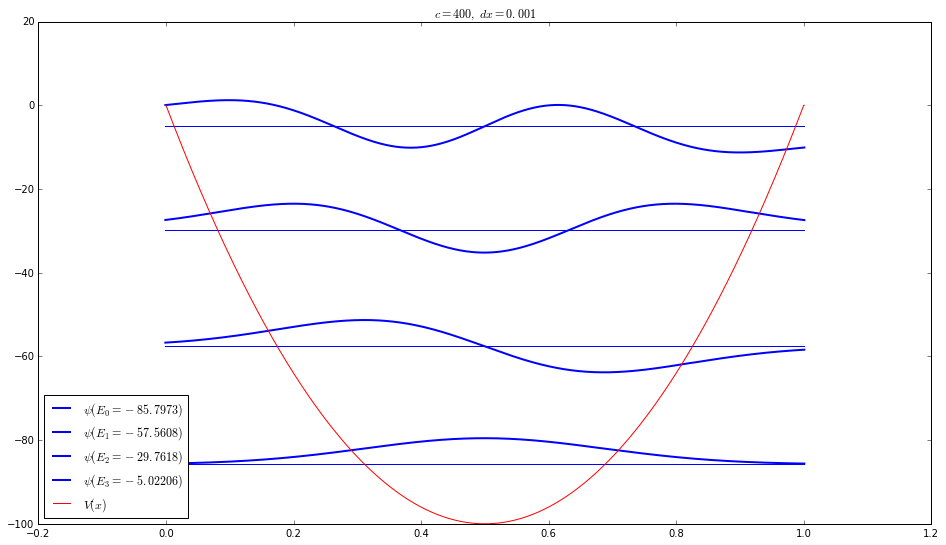

In [11]:
cV = 400

plt.figure()
plt.title('$c=%s,\; dx=%s$'%(cV,dx))
for n in range(numstates):
    print('+++ '+str(n)+'\'th bound state:')
    (E,psi) = findstate_match(cV,n,dx=dx,plottrials=False)
    print('E_'+str(n)+' =', E)
    xs = np.linspace(-dx,1+dx,len(psi))
    psi *= cV/16./numstates / np.max(psi) # rescale psi to look nicer in the plot
    plt.plot(xs,xs*0+E,'b')
    plt.plot(xs,psi+E,'b',label='$\psi(E_%d=%4g)$' % (n,E),linewidth=2)

pot = np.array([V(cV,x) for x in xs])
plt.plot(xs,pot,'r',label='$V(x)$')
plt.legend(loc='best')
plt.show()

We see all eigenenergies and wavefunctions conveniently at once.

#### More State Counting

We can also obtain the number of bound states for a few values of c.

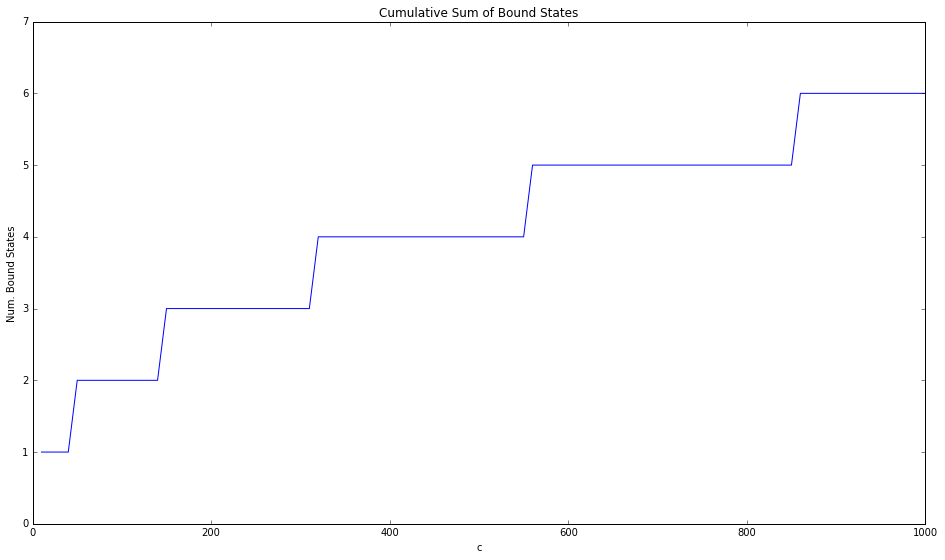

In [12]:
cvalues = np.linspace(10,1000,100)
boundstates = np.zeros(len(cvalues))
for n in range(len(cvalues)):
    boundstates[n]=numboundstates(cvalues[n],dx)
plt.figure()
plt.plot(cvalues,boundstates,'b')
plt.title('Cumulative Sum of Bound States')
plt.ylabel('Num. Bound States')
plt.xlabel('c')
plt.ylim(0,7)
plt.show()